# Example-13: Periodic fixed points (Henon mapping)

In [1]:
# In this example fixed point computation workflow is illustrated

# Periodic fixed points are computed using Newton root search for a set of random initials
# Filtering of unique chains done based on monodromy matrix trace for each fixed point point

In [2]:
# Import

import numpy

import jax
from jax import jit
from jax import vmap

# Test symplectic mapping and corresponding inverse

from tohubohu.util import forward2D
from tohubohu.util import inverse2D

# REM factory

from tohubohu import rem

# Fixed point

from tohubohu import iterate
from tohubohu import prime
from tohubohu import unique
from tohubohu import chain
from tohubohu import monodromy

# Iteration

from tohubohu import nest
from tohubohu import nest_list

# Plotting

from matplotlib import pyplot as plt
from matplotlib import colormaps

cmap = colormaps.get_cmap('viridis')
cmap.set_bad(color='lightgray')

In [3]:
# Set data type

jax.config.update("jax_enable_x64", True)

In [4]:
# Set device

device, *_ = jax.devices('cpu')
jax.config.update('jax_default_device', device)

In [5]:
# Set initial grid

n = 1001

qs = jax.numpy.linspace(-0.75, 1.0, n)
ps = jax.numpy.linspace(-0.75, 1.0, n)
xs = jax.numpy.stack(jax.numpy.meshgrid(qs, ps, indexing='ij')).swapaxes(-1, 0).reshape(n*n, -1)
xs.shape

(1002001, 2)

In [6]:
# Set indicator

fn = jit(rem(2**12, forward2D, inverse2D))

x = jax.numpy.array([0.00, 0.00])
k = jax.numpy.array([0.47, 0.00])

fn(x, k) ;

In [7]:
%%time

# Map indicator over a grid

out = jit(vmap(fn, (0, None)))(xs, k).block_until_ready()

CPU times: user 3min 12s, sys: 2 s, total: 3min 14s
Wall time: 36.6 s


In [8]:
# Winsorize data

data = numpy.log10(1.0E-16 + numpy.array(out.tolist()))
data[data < -15.0] = -15.0
data[data > 0.0] = 0.0
data = data.reshape(n, n)

In [9]:
# Set initial points for fixed point computation

size = 100

seed = jax.random.PRNGKey(0)
qs = jax.random.uniform(seed, shape=(size, ), minval=-0.75, maxval=1.0)

seed = jax.random.PRNGKey(1)
ps = jax.random.uniform(seed, shape=(size, ), minval=-0.75, maxval=1.0)

xs = jax.numpy.stack([qs, ps]).T

In [10]:
# Search for fixed points

order = 5
limit = 32

solver = jit(vmap(iterate(32, forward2D, order=order), (0, None)))
points = solver(xs, k)
points = points[~jax.numpy.any(jax.numpy.isnan(points), -1)]

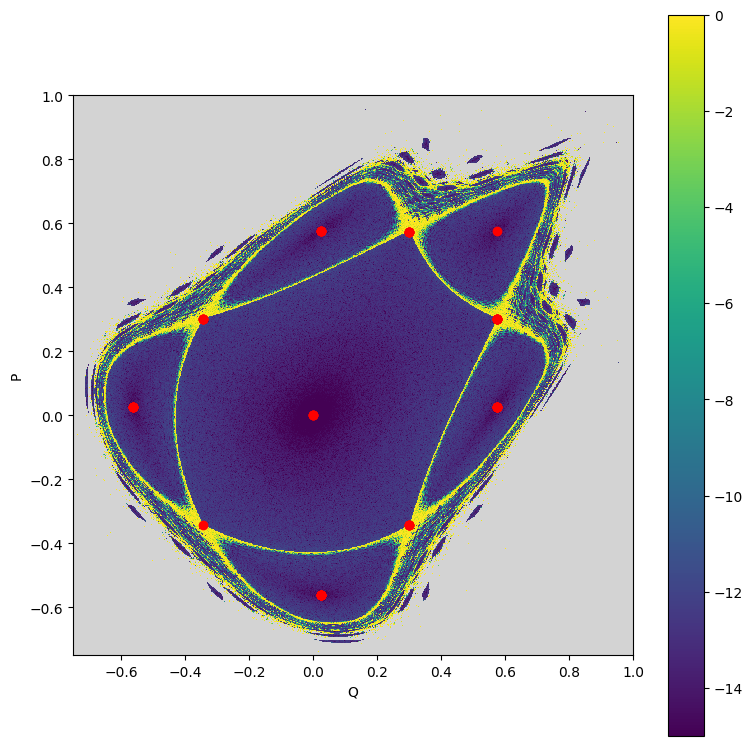

In [11]:
# Note, after removing nan values, we can still have values that are not actually a fixed point
# Additionaly, values corresponding to a smaller period can present
# And multiple identical values from different guess points converged to the same result

plt.figure(figsize=(8, 8))
plt.scatter(*points.T, color='red')
plt.imshow(data, aspect='equal', vmin=-15.0, vmax=0.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-0.75, 1., -0.75, 1.))
plt.xlabel('Q')
plt.ylabel('P')
plt.tight_layout()
plt.colorbar()
plt.show()

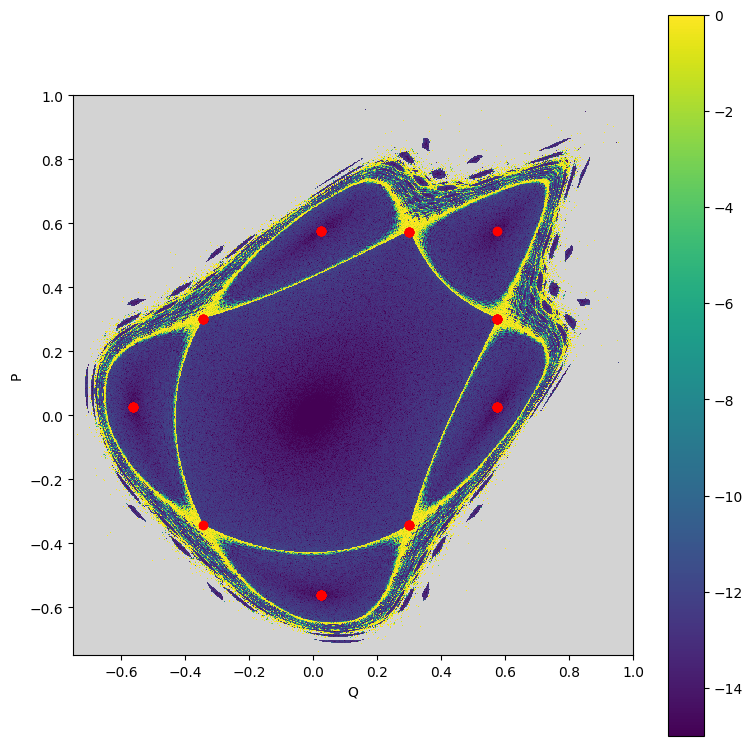

In [12]:
# Keep only prime fixed points

mask = jit(vmap(prime(forward2D, order=order, rtol=1.0E-9, atol=1.0E-9), (0, None)))(points, k)
points = points[mask]

plt.figure(figsize=(8, 8))
plt.scatter(*points.T, color='red')
plt.imshow(data, aspect='equal', vmin=-15.0, vmax=0.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-0.75, 1., -0.75, 1.))
plt.xlabel('Q')
plt.ylabel('P')
plt.tight_layout()
plt.colorbar()
plt.show()

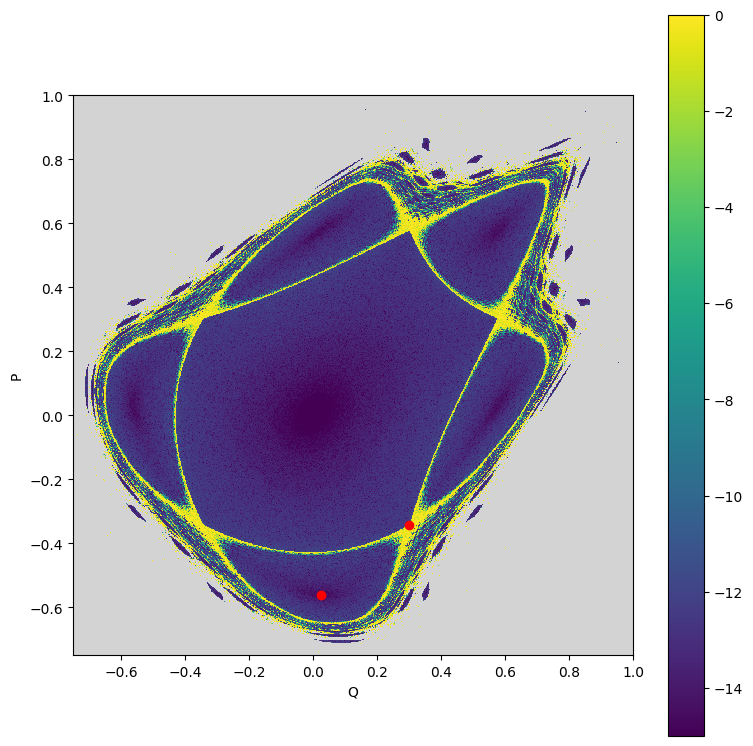

In [13]:
# Next step is to keep only unique chains

mask = unique(order, forward2D, points, k, tol=1.0E-9)
points = points[mask]

plt.figure(figsize=(8, 8))
plt.scatter(*points.T, color='red')
plt.imshow(data, aspect='equal', vmin=-15.0, vmax=0.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-0.75, 1., -0.75, 1.))
plt.xlabel('Q')
plt.ylabel('P')
plt.tight_layout()
plt.colorbar()
plt.show()

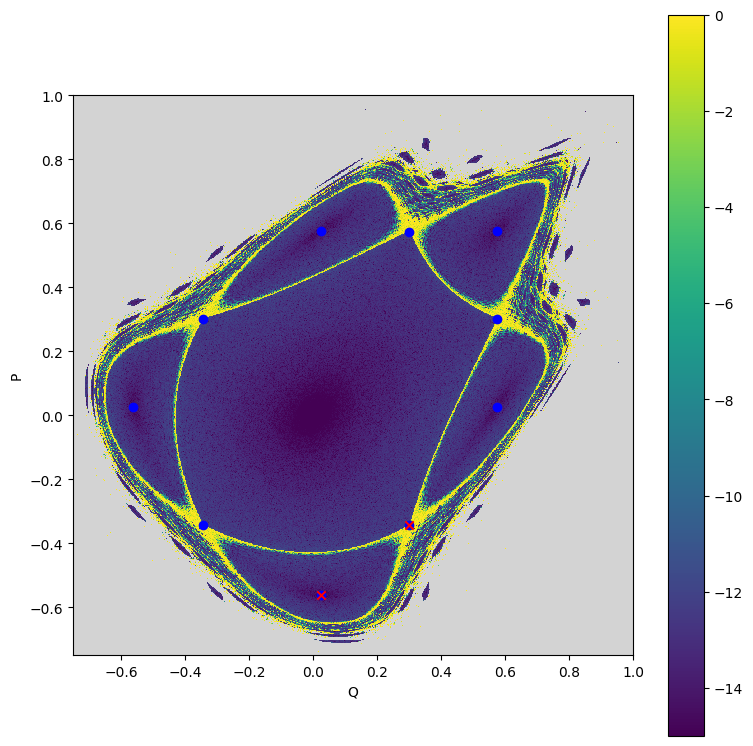

In [14]:
# Generate full chains (starting point is not included)

chains = jax.numpy.vstack(jit(vmap(chain(order, forward2D), (0, None)))(points, k))

plt.figure(figsize=(8, 8))
plt.scatter(*chains.T, color='blue')
plt.scatter(*points.T, color='red', marker='x')
plt.imshow(data, aspect='equal', vmin=-15.0, vmax=0.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-0.75, 1., -0.75, 1.))
plt.xlabel('Q')
plt.ylabel('P')
plt.tight_layout()
plt.colorbar()
plt.show()

In [15]:
# Fixed point type can be infered from monodromy eigenvalues

pe, ph = points
me, mh = jit(vmap(monodromy(order, forward2D), (0, None)))(points, k)

# EP

print(me)
print(jax.numpy.linalg.eigvals(me))
print()

# HP

print(mh)
print(jax.numpy.linalg.eigvals(mh))
print()

[[ 0.77219373 -1.11956497]
 [ 0.24845248  0.93479302]]
[0.85349338+0.52110369j 0.85349338-0.52110369j]

[[ 1.77774828 -0.34660376]
 [ 0.67008068  0.43186514]]
[1.57448519+0.j 0.63512823+0.j]



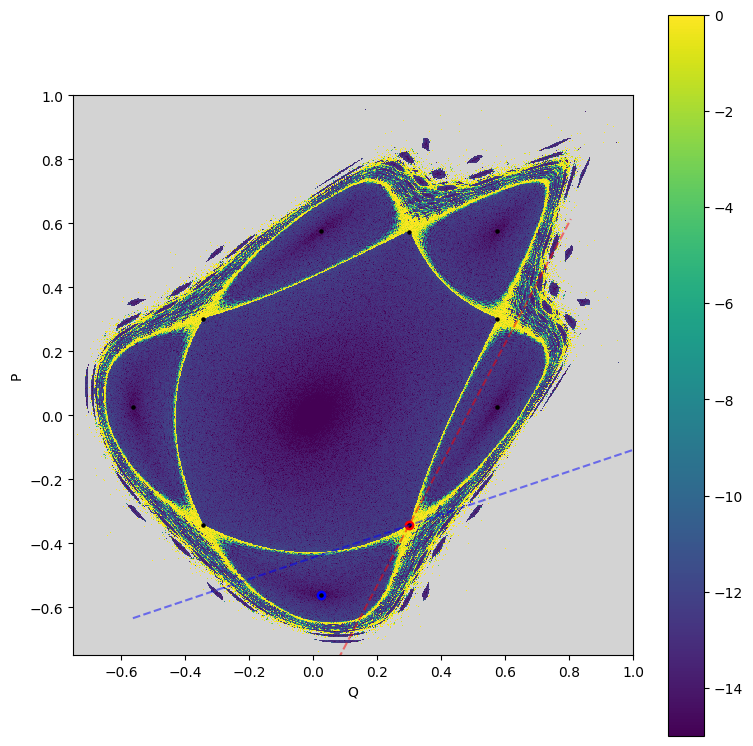

In [16]:
# HP directions

_, (va, vb) = jax.numpy.linalg.eig(mh)
 
la = ph + va.real*jax.numpy.linspace(-1.0, 1.0, 10).reshape(-1, 1)
lb = ph + vb.real*jax.numpy.linspace(-1.0, 1.0, 10).reshape(-1, 1)

plt.figure(figsize=(8, 8))
plt.plot(*la.T, color='blue', linestyle='dashed', alpha=0.5)
plt.plot(*lb.T, color='red', linestyle='dashed', alpha=0.5)
plt.scatter(*pe, color='blue')
plt.scatter(*ph, color='red')
plt.scatter(*chains.T, color='black', s=5)
plt.imshow(data, aspect='equal', vmin=-15.0, vmax=0.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-0.75, 1., -0.75, 1.))
plt.xlabel('Q')
plt.ylabel('P')
plt.tight_layout()
plt.colorbar()
plt.show()

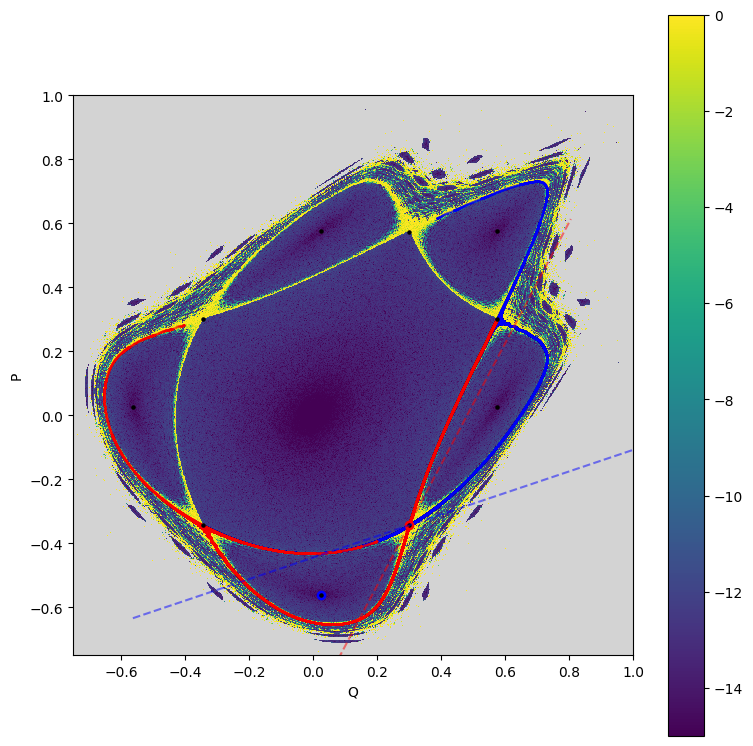

In [17]:
# Hyperbolic manifolds

epsilon = 1.0E-9

xa = ph + va.real*jax.numpy.linspace(-epsilon, epsilon, 4096).reshape(-1, 1)
xb = ph + vb.real*jax.numpy.linspace(-epsilon, epsilon, 4096).reshape(-1, 1)
xs = jax.numpy.vstack([xa, xb])

ma = vmap(jit(nest_list(64, nest(order, forward2D))), (0, None))(xs, k).reshape(-1, 2)
mb = vmap(jit(nest_list(64, nest(order, inverse2D))), (0, None))(xs, k).reshape(-1, 2)

plt.figure(figsize=(8, 8))
plt.scatter(*ma.T, color='blue', alpha=0.25, s=0.1)
plt.scatter(*mb.T, color='red', alpha=0.25, s=0.1)
plt.plot(*la.T, color='blue', linestyle='dashed', alpha=0.5)
plt.plot(*lb.T, color='red', linestyle='dashed', alpha=0.5)
plt.scatter(*pe, color='blue')
plt.scatter(*ph, color='red')
plt.scatter(*chains.T, color='black', s=5)
plt.imshow(data, aspect='equal', vmin=-15.0, vmax=0.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-0.75, 1., -0.75, 1.))
plt.xlabel('Q')
plt.ylabel('P')
plt.tight_layout()
plt.colorbar()
plt.show()